In [1]:
# Remember to update your path
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('C:/Linux_home/Qishi/QishiQR')

from pathlib import Path

from Backtesting.Vectorized.cross_compare import *
from Backtesting.Vectorized.models import *

from Utils.lm import gen_strategy, LM_model
from Utils.MajorContract_split import MajorContracts

import json
import warnings
warnings.filterwarnings(action='ignore')

# ====== Initial Configuration ========

try:
    with open('../config.json','r') as f:
        config = json.load(f)
except:
    print("Failed to find the configuration file.")
        
DATA_DIR = config['Tick path']
OUTPUT_DIR = config['Output path']
Strategy_DIR = config['Strategy path']
Major_DIR = config['Major path']
model_order = config['Max model order']
number_of_states = config['State number']
freq = config['Frequency']
offset = config['Offset']
tca = None



# Method
After we obtain the ticks and before we generate `tick_all_sequence`, in `MajorContracts.create_major_overlap()`, we add a split indicator `9`(Line 157-158). The insertion is done by a function
`session_break`. 

```python
    def session_break(self, tick_all, start_day, end_day, break_time, split_col='Direction'):
        """
        Insert breaking timepoints in the tick tick_all
        
        Args:
            start_day: str. yyyy-mm-dd
            break_time: str. hh:mm:ss
        """
        if type(break_time) is str:
            break_time = [break_time]
        break_indicator = []

        for bt in break_time:
            start = pd.to_datetime(start_day) + pd.to_timedelta(bt)
            end   = pd.to_datetime(end_day) + pd.to_timedelta(bt)
            break_indicator.append(pd.date_range(start, end, freq='1d'))
        time_index = reduce(lambda x,y: x.append(y), break_indicator)

        for idx in time_index:
            tick_all.loc[idx,split_col] = 9

        tick_all.sort_index(inplace=True)

```



# Bu test

## Build time series of Major contracts without session breaks

In [3]:
bu_mj = MajorContracts(symbol='bu', split_time='2016-7-1', topdir='C:/Linux_home/Qishi/tick2016', 
                       maturity={'1606':['2015-11-1','2016-5-1'], 
                                 '1609':['2016-2-1','2016-8-1'], 
                                 '1612':['2016-6-1','2016-11-15'],
                                 '1706':['2016-10-15','2017-1-31']}, 
                       transitions={'1606':'2016-3-1', '1609':'2016-7-1', '1612':'2016-11-1', '1706':'2017-1-1' },
                       freq=freq, offset=offset)

In [8]:
df_bu_train, df_bu_test, ptb = bu_mj.create_major_overlap()

bu1606 C:/Linux_home/Qishi/tick2016/bu
0
ID trade_range transition_begin transition_end
1606 ['2015-11-1', '2016-5-1'] 2016-01-01 00:00:00 2016-03-01 00:00:00
probability table:  20160104.0 20160229.0
bu1609 C:/Linux_home/Qishi/tick2016/bu
0
ID trade_range transition_begin transition_end
1609 ['2016-2-1', '2016-8-1'] 2016-03-01 00:00:00 2016-07-01 00:00:00
probability table:  20160229.0 20160630.0
bu1612 C:/Linux_home/Qishi/tick2016/bu
0
ID trade_range transition_begin transition_end
1612 ['2016-6-1', '2016-11-15'] 2016-07-01 00:00:00 2016-11-01 00:00:00
bu1706 C:/Linux_home/Qishi/tick2016/bu
0
ID trade_range transition_begin transition_end
1706 ['2016-10-15', '2017-1-31'] 2016-11-01 00:00:00 2016-12-31 00:00:00


## Build time series of Major contracts with session breaks

In [17]:
# Put breakpoints at the time where no transactions are allowed
session_split =  ['10:35:00','11:40:00', '17:00:00', '03:00:00']
df_bu_train_split, df_bu_test_split, ptb_split = bu_mj.create_major_overlap(session_split)

bu1606 C:/Linux_home/Qishi/tick2016/bu
0
ID trade_range transition_begin transition_end
1606 ['2015-11-1', '2016-5-1'] 2016-01-01 00:00:00 2016-03-01 00:00:00
probability table:  20160104.0 20160229.0
bu1609 C:/Linux_home/Qishi/tick2016/bu
0
ID trade_range transition_begin transition_end
1609 ['2016-2-1', '2016-8-1'] 2016-03-01 00:00:00 2016-07-01 00:00:00
probability table:  20160229.0 20160630.0
bu1612 C:/Linux_home/Qishi/tick2016/bu
0
ID trade_range transition_begin transition_end
1612 ['2016-6-1', '2016-11-15'] 2016-07-01 00:00:00 2016-11-01 00:00:00
bu1706 C:/Linux_home/Qishi/tick2016/bu
0
ID trade_range transition_begin transition_end
1706 ['2016-10-15', '2017-1-31'] 2016-11-01 00:00:00 2016-12-31 00:00:00


# Compare training/test data

In [18]:
df_bu_test.equals(df_bu_test_split)

True

In [19]:
df_bu_train.equals(df_bu_train_split)

True

# Compare the probability table

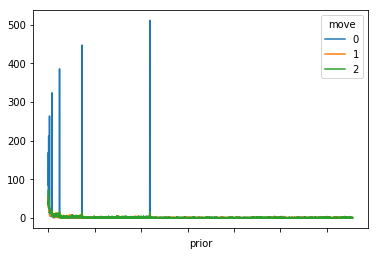

In [29]:
(ptb['1609'][['0','1','2']] - ptb_split['1609'][['0','1','2']]).plot()

Examine the spike.

In [33]:
ptb_diff = ptb['1609'][['0','1','2']] - ptb_split['1609'][['0','1','2']]
ptb_diff[ptb_diff['0']>150]

move,0,1,2
prior,,,
0,170,54,72
00,213,36,43
000,264,19,27
0000,324,14,18
00000,386,13,16
000000,448,12,15
0000000,512,10,15


It can be shown that the spike is due to long sequences with 0 price movements, and it is resonable. We can drop them and plot the difference again.

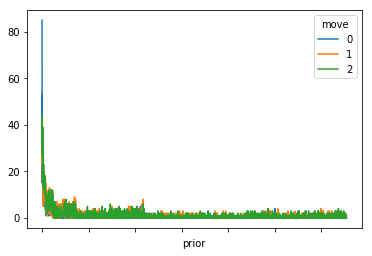

In [38]:
ptb_diff.drop(ptb_diff[ptb_diff['0']>150].index).plot()
